In [1]:
import numpy as np
import os
import pandas as pd
import tools
from tqdm import tqdm
from matplotlib import pyplot as plt
import measures as ms
import seaborn as sns

from scipy.stats import ttest_rel, wilcoxon

import pdb
%load_ext autoreload
%autoreload 2

## Params

In [2]:
path_exp = "/home/jovyan/data/PNN.A-CMWMRawData/"
path_probe_trials = "PNN.A-C.MWM.probe/"
path_train_trials ={
    'Hid': "PNN.A-C.MWM.HID.Train/",
    'Rev': "PNN.A-C.MWM.REV.Train/"}

fname_genotypes = "MWMGenotypes.xlsx"

#radius platform in cm
r_platform = 6

# assume the water maze radius is 60 cm *** Double Check ***
r_maze = 61

## Load metadata

In [3]:
ls_info = []
# For both Hidden and Reversal trials ...
for key, val in path_train_trials.items():
    print(key)
    # ... load trials
    df_trialinfo = tools.extract_trialinfo(path_exp+val)
    # ... as well as information about the maze
    df_mazeinfo = tools.extract_mazeinfo(path_exp+val, key)
    df_info_i = pd.merge(
        df_trialinfo,
        df_mazeinfo[['day', 'experiment', 'cohort', 'phase', 'platform_xy']],
        on=['day', 'experiment', 'cohort', 'phase'], how='outer')
    ls_info.append(df_info_i)

df_info = pd.concat(ls_info, ignore_index=True)

Hid
Rev


#### Include genotype data for each individual


In [4]:
def handle_values(val):
    if isinstance(val, str) and '*' in val:
        return val.replace('*', '')  # Replace '*' with an empty string
    return val
df_genotypes = pd.read_excel(path_exp+fname_genotypes, converters={'Subj': handle_values}, usecols=[0, 1, 2])
df_genotypes.set_index('Subj', inplace=True)

# merge both
df_info = pd.merge(df_info, df_genotypes[['sex', 'Geno']], left_on='animal_id', right_index=True, how='left')
df_info.reset_index(drop=True, inplace=True)

#### Add missing experimental day

In [5]:
# add experimental day
df_info['exp_day'] = np.nan

# 1. during HID phase exp day is just normal day
sel = df_info['phase'] == 'Hid'
df_info.loc[sel, 'exp_day'] = df_info.loc[sel, 'day']

#sel = ((df_info['phase'] == 'Hid') & (df_info['day'] == 'probe'))
#df_info.loc[sel, 'exp_day'] = 5

# 2. during Rev phase experimental day has to be shifted by 4 initial training days and the first probe day.
# a) training
sel = ((df_info['phase'] == 'Rev') & (df_info['day'] != 'probe'))
df_info.loc[sel, 'exp_day'] = df_info.loc[sel, 'day'].astype(int)+5

# b) probe
#sel = ((df_info['phase'] == 'Rev') & (df_info['day'] == 'probe'))
#df_info.loc[sel, 'exp_day'] = 14

#### For estimating perseverance, extract old platform location from last day of initial learning

In [6]:
hid_last_day = df_info[
    (df_info['phase'] == 'Hid') &
    (df_info['trial'] == 1) &
    (df_info['exp_day'] == 4)
][['animal_id', 'platform_xy']]

hid_last_day.rename(columns={"platform_xy": "platform_xy_old"}, inplace=True)

# Then, merge the extracted platform_xy values with the original data
df_info = df_info.merge(hid_last_day, on='animal_id')

# Finally, fill the "platform_old_xy" column with NaN for rows where phase is not "Rev"
df_info.loc[df_info['phase'] != 'Rev', 'platform_xy_old'] = np.nan

In [7]:
# Enable ordering across experimental type, day and trial
ls_df_info_i = []
for i in df_info['animal_id'].unique():
    df_info_i = df_info[df_info['animal_id'] == i]
    df_info_i = df_info_i.sort_values(['Geno', 'phase', 'exp_day', 'trial'])
    df_info_i['order'] = np.arange(len(df_info_i))
    df_info_i['grp_day_trial'] = df_info_i['exp_day'].astype(int).astype(str) + '_' + df_info_i['trial'].astype(str)
#    df_info_i['grp_day_trial'] = df_info_i['phase'] + '_' + df_info_i['exp_day'].astype(int).astype(str) + '_' + df_info_i['trial'].astype(str)
    df_info_i['grp_day'] = df_info_i['phase'] + '_' + df_info_i['exp_day'].astype(int).astype(str)
    ls_df_info_i.append(df_info_i)
df_info = pd.concat(ls_df_info_i)
df_info = df_info.reset_index(drop=True)

#### Estimate box boundaries based on overlaid trajectories

In [8]:
bool_display = False

# points to plot
ls_pts = ['platform_xy']

gp_pts = df_info.groupby(ls_pts)
for i, gp_i in tqdm(gp_pts):  
    ls_xy = []
    for j, row_j in gp_i.iterrows():
        # load recording
        path_j = row_j['relative_path']
        rec = tools.load_recording(path_j)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        ls_xy.append(xy)
    xy_all = np.vstack(ls_xy)

    # estimate center and radius based on max/min in x and y.
    center_x, center_y, radius = tools.detect_circle_boundaries(xy_all[:, 0], xy_all[:, 1])

    # apply correction factor
    #radius = radius * r_maze_corr
    radius = r_maze
    
    # store in dataframe
    df_info.loc[gp_i.index, 'center_x'] = center_x
    df_info.loc[gp_i.index, 'center_y'] = center_y
    df_info.loc[gp_i.index, 'radius'] = radius
    
    if bool_display:
        # Create a scatter plot
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        ax.scatter(xy_all[:, 0], xy_all[:, 1], s=1)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_title(i)
    
        # plot cirlce
        circle_wall = plt.Circle((center_x, center_y), radius, color='red', fill=False)
        ax.add_patch(circle_wall)
    
        # plot platform
        circle_pltfrm = plt.Circle(i[0], r_platform, color='red', fill=False)
        ax.add_patch(circle_pltfrm)
    
        # plot quadrant points
        for j in range(1,5):
            circle_pltfrm = plt.Circle(i[j], 1, color='orange', fill=True)
            ax.add_patch(circle_pltfrm)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.title(i)
        plt.legend()
        plt.grid(True)
        plt.show()


100%|███████████████████████████████████████████████████████████████████| 23/23 [04:02<00:00, 10.55s/it]


## Classify Strategy

In [9]:
fname_res = 'data/strategy/df_res_all.pckl'
compute=False

In [10]:
print(len(df_info))
if compute:
    ls_res = []
    for i, row_i in tqdm(df_info.iterrows()):
        
        # load recording
        path_i = row_i['relative_path']
        rec = tools.load_recording(path_i)
        # extract positions
        xy = np.hstack([np.array(rec['X center']), np.array(rec['Y center'])])
        # extract trial time
        t_trial = np.array(rec['Trial time']).flatten()
        # get recording time
        t_rec = np.array(rec['Recording time']).flatten()

        # center coordinates
        xy_center = np.array([
            row_i['center_x'],
            row_i['center_y']])
        xy -= xy_center

        ## exclude nan values
        #xy, t = tls.exclude_nan_values(xy, t)

        ## interpolate xy values
        #xy, t = tls.interpolate_xy_values(xy, t, dt)

        # get current platform location
        xy_pltfrm = np.array(row_i['platform_xy'])
        
        # get old platform location
        xy_pltfrm_old = np.array(row_i['platform_xy_old'])

        # transform arena and path info for rtrack
        # arena
        s_arena = (
            'time.units = s\n' +
            'type = mwm\n' +
            'trial.length = 60\n'+
            'arena.bounds = circle 0.0 0.0 ' + str(row_i['radius'])+'\n'+
            'goal = circle '+str(xy_pltfrm[0]) + ' ' + str(xy_pltfrm[1]) + ' ' + str(r_platform) + '\n')
        if np.all(~pd.isna(xy_pltfrm_old)):
            s_arena += 'old.goal = circle '+str(xy_pltfrm_old[0]) + ' ' + str(xy_pltfrm_old[1]) + ' ' + str(r_platform)

        # path
        df_tmp = pd.DataFrame({
            'Time': t_rec,
            'X': xy[:, 0],
            'Y': xy[:, 1]})

        # create temporary directory 
        with TemporaryDirectory() as temp_dir:
            #temp_dir = mkdtemp()
            # store and read arena
            fname_arena = temp_dir+'/arena.txt'
            with open(fname_arena, 'w') as f:
                f.write(s_arena)

            # read arena
            arena = rtrack.read_arena(fname_arena)

            # store path
            fname_path = temp_dir+'/path.csv'
            df_tmp.to_csv(
                fname_path,
                sep=',',
                #header=False,
                index=False)

            dct_args = {'track.format': 'raw.csv'}
            # load path
            path = rtrack.read_path(
                fname_path,
                arena,
                **dct_args)

            metrics = rtrack.calculate_metrics(path, arena)

        # define strategy
        strategy = rtrack.call_strategy(metrics)

        # convert to pandas dataframe
        dct_strat = {x: v for x, v in strategy.items()}
        with localconverter(ro.default_converter + pandas2ri.converter):
            df_strat = ro.conversion.rpy2py(dct_strat['calls'])
        assert len(df_strat) == 1

        res = {
            'strategy_idx': int(df_strat['strategy'].iloc[0]),
            'strategy_name': df_strat['name'].iloc[0],
            'strategy_confidence': df_strat['confidence'].iloc[0]}
        # get also confidences for all other strategies
        for i in range(1, 10):
            res[str(i) + '_conf'] = df_strat[str(i)].iloc[0]
        ls_res.append(res)

    df_res = pd.DataFrame(ls_res)
    df_res.to_pickle(fname_res)
else:
    df_res = pd.read_pickle(fname_res)
df_info = df_info.join(df_res)

1952


## Plot strategies per trial

In [11]:
# define color of each strategy
dct_strat = {
# non spatial
    'thigmotaxis': "#481c6e",
    'circling': "#453581",
    'random path': "#3d4d8a",
    'scanning': "#34618d",
    'chaining': "#2b748e",
# spatial    
    'directed search': "#67cc5c",
    'corrected search': "#98d83e",
    'corrected path': "#cde11d",
    'direct path': "#fde725",
    'perseverance': "#440154",
}

# define group names in accordance to other figures
dct_treat = {
    'PNN': 'Cre+',
    'WT': 'Cre-'}

# Define non-spatial and spatial
strat_group = {
    'non-spatial':[
         'chaining',
         'scanning',
         'random path',
         'circling',
         'thigmotaxis'   
    ],
    'spatial': [
         'perseverance',
         'direct path',
         'corrected path',
         'corrected search',
         'directed search',
         ]
}

In [12]:
# limit data to only train
df_train = df_info[df_info['day']!='probe']

In [13]:

# list of all strategies
all_strat = [item for sublist in strat_group.values() for item in sublist]

In [14]:
# Calculate fraction of each strategy per day and treatment
grp_var = 'grp_day_trial'
grp_day_treatment = df_train.groupby([grp_var, 'Geno', 'sex'])

res = []
for grp_name, grp_dat in grp_day_treatment:
    ls_strat, cnt_strat = np.unique(
        grp_dat['strategy_name'], return_counts=True)
    
    # add strategies which are not in list
    strat_add = []
    cnt_add = []
    for strat_i in all_strat:
        if strat_i not in ls_strat:
            strat_add.append(strat_i)        
            cnt_add.append(0)
    ls_strat = np.concatenate((ls_strat, strat_add))
    cnt_strat = np.concatenate((cnt_strat, cnt_add))
    
    # calculate fraction of each strategy
    frac_strat = cnt_strat/len(grp_dat)
    
    res_i = {n:v for n, v in zip(ls_strat, frac_strat)}
    res_i[grp_var] = grp_name[0]
    res_i['Geno'] = grp_name[1]
    res_i['sex'] = grp_name[2]
    res_i['exp_day'] = int(grp_dat['exp_day'].unique()[0])
    res_i['phase'] = grp_dat['phase'].unique()[0]
    res.append(res_i)
df_res = pd.DataFrame(res)

# resort df_res
grp_day_order = list(df_info[grp_var].unique())
df_res[grp_var] = df_res[grp_var].astype("category")
df_res[grp_var] = df_res[grp_var].cat.set_categories(grp_day_order)
df_res = df_res.sort_values([grp_var])

# determine existing strategies

existing_strat = []
for key in dct_strat.keys():
    if key in df_res.keys():
        existing_strat.append(key)


df_res.columns = pd.CategoricalIndex(
    df_res.columns.values, 
    ordered=True, 
    categories=list(dct_strat.keys())+['grp_day_trial', 'exp_day', 'Geno', 'sex', 'phase'] )


#df_res.columns = pd.CategoricalIndex(
#    df_res.columns.values, 
#    ordered=True, 
#    categories=existing_strat[::-1]+['grp_day_trial', 'exp_day', 'Geno', 'sex'] )

df_res = df_res.sort_index(axis=1)

#df_res = df_res.sort_index(axis=1)

In [16]:
### add adjusted days for plotting
sorted_groups = {
        'Hid_1': 1,
        'Hid_2': 2,
        'Hid_3': 3,
        'Hid_4': 4,
        'Rev_6': 6,
        'Rev_7': 7,
        'Rev_8': 8,
        'Rev_9': 9,
        'Rev_10': 10,
        'Rev_11': 11,
        'Rev_12': 12,
        'Rev_13': 13,
}

/tmp/ipykernel_2491/588392541.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # Adjust the layout
/tmp/ipykernel_2491/588392541.py:91: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()  # Adjust the layout


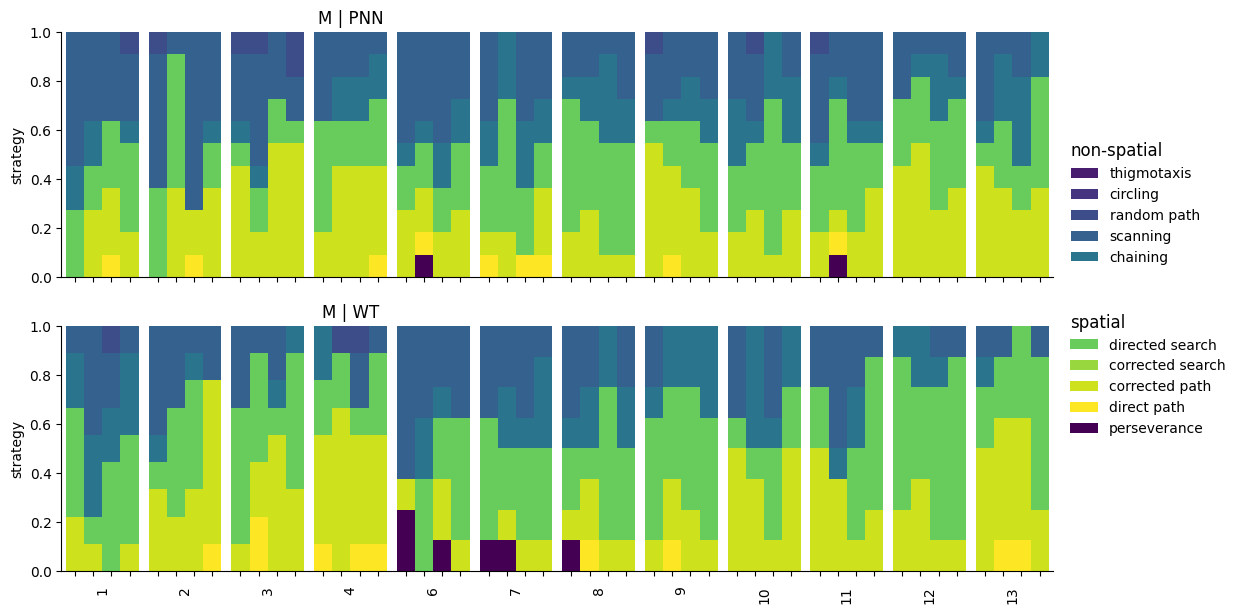

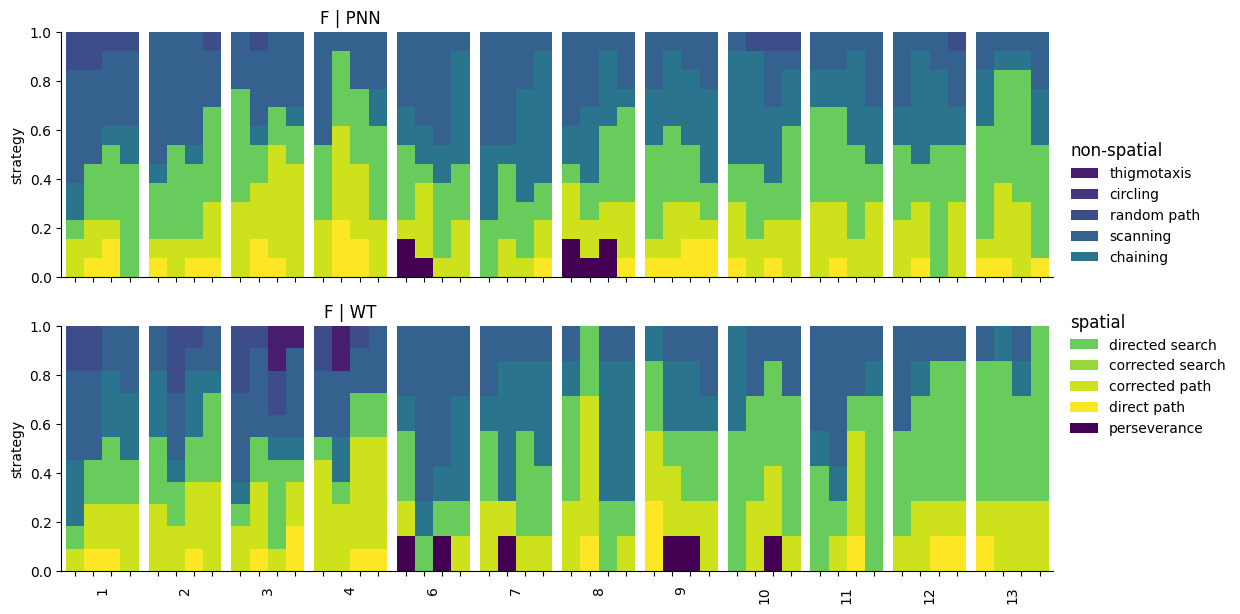

In [23]:

ls_pos = [
    [2., 0.0],
    [2.15, 0.5],
]
# calculate width ratios for each subplot
n, c = np.unique(df_res['exp_day'], return_counts=True)
width_ratios = c
width_ratios = width_ratios/np.sum(width_ratios)

for i, sex_i in enumerate(['M', 'F']):

    fig, ax = plt.subplots(
        2,
        len(n),
        figsize=(np.sum(c)/15., 7),
        gridspec_kw={
            'width_ratios': width_ratios,
            'wspace': 0.01,
        }
    )
    
    for j, treat_j in enumerate(['PNN', 'WT']):
        for m, day_m in enumerate(sorted_groups.values()):
    
            df_jm = df_res[
                (df_res['sex']==sex_i) &
                (df_res['Geno']==treat_j) & 
                (df_res['exp_day']==day_m)
            ]
            df_jm = df_jm[[grp_var]+list(dct_strat.keys())[::-1]]
            plt_jm = df_jm.plot(
                kind='bar',
                x=grp_var,
                stacked=True,
                title=treat_j,
                ylabel='strategy',
                ax=ax[j,m],
                width=1,
                #color=list(dct_strat.values()),
                color=list(dct_strat.values())[::-1],
            )
            plt_jm.get_legend().remove()
            ax[j,m].set_ylim(0, 1)
    
            ax[j,m].spines.right.set_visible(False)
            ax[j,m].spines.top.set_visible(False)
            ax[j,m].set_xticklabels('')    
    
            if m!=0:
                ax[j,m].spines.left.set_visible(False)
                ax[j,m].set_yticks([])
                ax[j,m].set_ylabel('')          
            
            ax[j,m].set_title('')
            ax[j,m].set_xlabel('')
    
            if j==1:
                ax[j,m].set_xlabel(day_m, rotation=90)
            
            if m==3:
                #ax[j,m].set_title(sex_i + ' | ' +dct_treat[treat_j])
                ax[j,m].set_title(sex_i + ' | ' +treat_j)
        
        handles, labels = ax[j, -1].get_legend_handles_labels()
    
        for jj, (k, v) in enumerate(strat_group.items()):
            
            hndls_lbls_j = np.array(
                [[h, s] for h, s in zip(handles, labels) if s in v],
                dtype=object)
            hndls_j = hndls_lbls_j[:, 0]
            lbls_j = hndls_lbls_j[:, 1]
            
            if j==jj:
                leg_i = ax[j, -1].legend(
                    #hndls_j,
                    #lbls_j,
                    reversed(hndls_j),
                    reversed(lbls_j),
                    title=k,
                    alignment='left',
                    title_fontsize='large')
                #leg_i._legend_box.align = "left"
                sns.move_legend(
                    ax[j, -1],
                    "lower center",
                    bbox_to_anchor=ls_pos[j],
                    frameon=False, 
                )

    fig.tight_layout()  # Adjust the layout
    fig.savefig("figures/fraction_spatial_strategies_"+sex_i+".pdf")
    fig.savefig("figures/fraction_spatial_strategies_"+sex_i+".svg")

               

### Group into categories

In [24]:
def determine_strategy_category(row, strat_dict, col_name_strat='strategy_name'):
    strat_name = row[col_name_strat]
    strat_cat = [k for k, v in strat_dict.items() if strat_name in v][0]
    return strat_cat

In [26]:
# classify strategies according to the groups
df_train['strat_cat'] = df_train.apply(determine_strategy_category, axis=1, args=(strat_group, 'strategy_name'))
# convert to one hot encoding
df_dummies = pd.get_dummies(df_train['strat_cat'], columns=['strat_cat'], prefix='is')
df_train = pd.concat([df_train, df_dummies], axis=1)


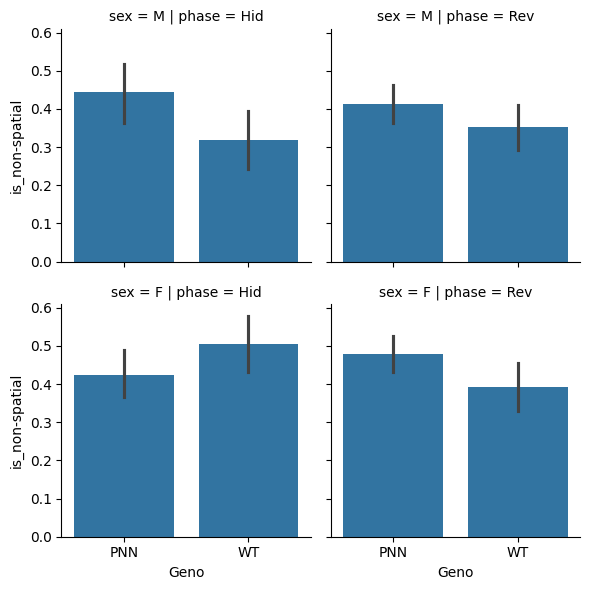

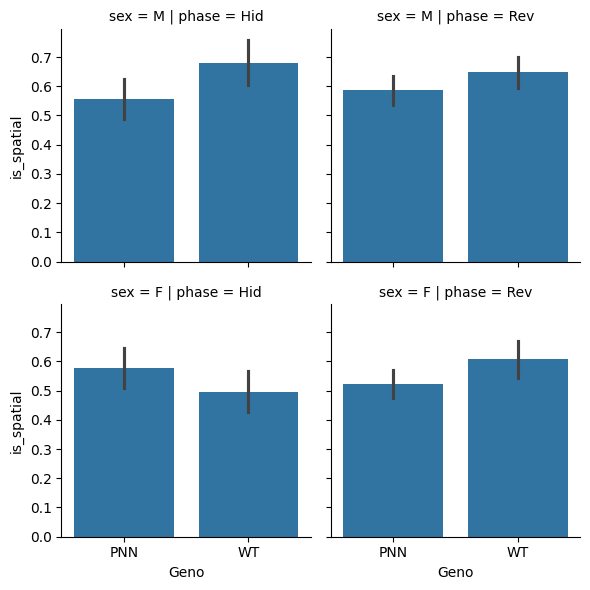

In [27]:
for cat_i in np.unique(df_train['strat_cat']):
    
    # Create a FacetGrid with 'phase' as the column variable and 'sex' as the row variable
    g = sns.FacetGrid(data=df_train, col="phase", row="sex")
    
    # Map a bar plot of trial duration to each grid item
    g.map(sns.barplot, "Geno", 'is_'+cat_i, order=['PNN', 'WT'])

## Compare first and last day of training
For every animal, determine fraction of trials using spatial strategy at day 1 and day 8

In [29]:
strat_group = {
    'non-spatial':[
         'chaining',
         'scanning',
         'random path',
         'circling',
         'thigmotaxis'   
    ],
    'spatial': [
         'perseverance',
         'direct path',
         'corrected path',
         'corrected search',
         'directed search',
         ]
}

def convert_pvalue_to_asterisks(pvalue):
    # Define a function to convert p-values to asterisks
    if pvalue <= 0.0001:
        return "****"
    elif pvalue <= 0.001:
        return "***"
    elif pvalue <= 0.01:
        return "**"
    elif pvalue <= 0.05:
        return "*"
    return "ns"


In [30]:
df_train['strat_cat_spatial'] = df_train.apply(determine_strategy_category, axis=1, args=(strat_group, 'strategy_name'))
df_train.loc[:, 'is_spatial'] = df_train.apply(lambda row: True if row['strat_cat_spatial'] == 'spatial' else False, axis=1)

grp_id_day = df_train.groupby(['animal_id', 'exp_day', 'sex', 'Geno', 'phase'])
# get fraction
frac_spatial = grp_id_day['is_spatial'].mean()
# convert to dataframe
df_frac_id_day_spatial = frac_spatial.reset_index()


Hid
<function ttest_rel at 0x7f9c23ac36d0>
For sex = 'F', Geno = 'PNN':
  T-statistic: -3.426241444320964
  P-value: 0.005020376847514085
For sex = 'F', Geno = 'WT':
  T-statistic: -1.3445852909056284
  P-value: 0.20846275856690744
For sex = 'M', Geno = 'PNN':
  T-statistic: -1.3046561461068844
  P-value: 0.22123504663759805
For sex = 'M', Geno = 'WT':
  T-statistic: -2.412090756622109
  P-value: 0.042369748222793685
Rev
<function ttest_rel at 0x7f9c23ac36d0>
For sex = 'F', Geno = 'PNN':
  T-statistic: -2.280350850198276
  P-value: 0.04165185454018319
For sex = 'F', Geno = 'WT':
  T-statistic: -3.3824071260127297
  P-value: 0.014813722759443312
For sex = 'M', Geno = 'PNN':
  T-statistic: -0.9439751632913288
  P-value: 0.3674302558285506
For sex = 'M', Geno = 'WT':
  T-statistic: -5.612486080160912
  P-value: 0.000805367429521206


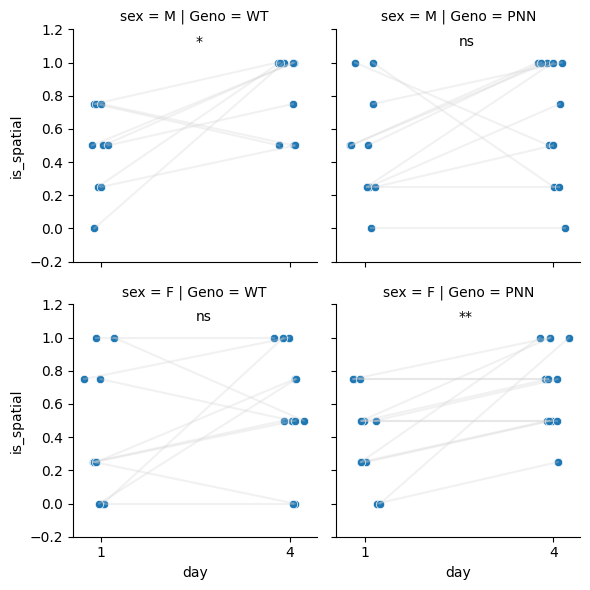

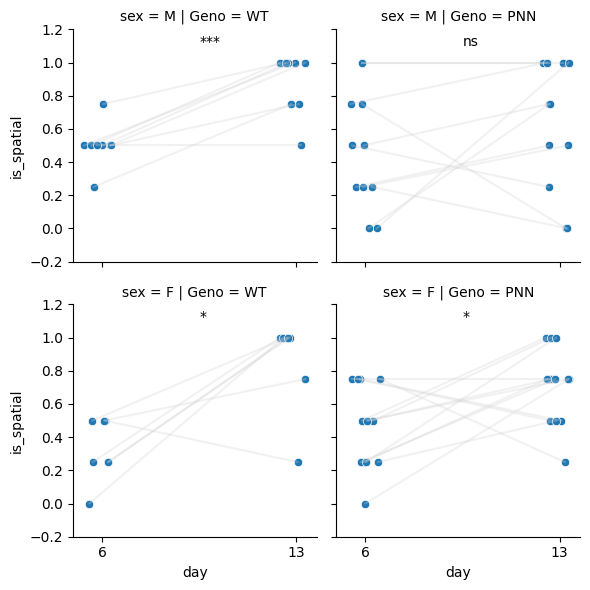

In [34]:
test = ttest_rel

for phase_i in ['Hid', 'Rev']:
    print(phase_i)
    
    df = df_frac_id_day_spatial[(df_frac_id_day_spatial['phase']==phase_i)]
    day_start = df['exp_day'].min()
    day_stop = df['exp_day'].max()
    day_delta = day_stop-day_start
    df = df[df['exp_day'].isin([day_start, day_stop])]
    
    # Calculate the p-values and asterisks for each group
    grouped = df.groupby(['Geno', 'sex'])
    
    pvalues = grouped.apply(lambda group: test(group[group['exp_day'] == day_start]['is_spatial'], group[group['exp_day'] == day_stop]['is_spatial']).pvalue)
    asterisks = pvalues.apply(convert_pvalue_to_asterisks)
    # Create a dictionary that maps ('Geno', 'sex') to asterisks
    asterisks_dict = {group: asterisk for group, asterisk in zip(pvalues.index, asterisks)}
    
    # Create a mapping from 'animal_id' to a unique shift value for each group
    shift_values = np.linspace(-.05*day_delta, .05*day_delta, grouped['animal_id'].nunique().max())
    for (geno, sex), group in grouped:
        animal_ids = group['animal_id'].unique()
        shift_mapping = dict(zip(animal_ids, shift_values[:len(animal_ids)]))
        df.loc[group.index, 'exp_day_shifted'] = df.loc[group.index, 'exp_day'] + df.loc[group.index, 'animal_id'].map(shift_mapping)
    
    # Add a small jitter
    df.loc[:, 'exp_day_shifted'] = df['exp_day_shifted'] + np.random.uniform(-.05*day_delta, .05*day_delta, size=len(df))

    # Create a FacetGrid object
    g = sns.FacetGrid(df, col="Geno", row="sex")
    
    # Define a custom function to plot
    def plot_lines(data, **kwargs):
        animal_ids = data['animal_id'].unique()
        for animal_id in animal_ids:
            animal_data = data[data['animal_id'] == animal_id]
            sns.lineplot(data=animal_data, x='exp_day_shifted', y='is_spatial', color='lightgrey', alpha=0.3, legend=False)
    
    # Map the custom lineplot to the FacetGrid
    g.map_dataframe(plot_lines)
    
    # Map the scatterplot to the FacetGrid
    g.map_dataframe(sns.scatterplot, x="exp_day_shifted", y="is_spatial")
    
    # Create a list of tuples that represent the row and column indices of each group
    indices = [(i, j) for i in range(len(df['sex'].unique())) for j in range(len(df['Geno'].unique()))]
    
    # Add the asterisks to the plot
    for i, row_name in enumerate(g.row_names):
        for j, col_name in enumerate(g.col_names):
            # Get the corresponding asterisk
            asterisk = asterisks_dict.get((col_name, row_name), '')
    
            # Add the asterisk to the subplot
            g.axes[i, j].text(day_start+(day_stop-day_start)/2., 1.1, asterisk, ma='center')
    
    # Limit xticks to 1 and 8
    g.set(ylim=[-0.2, 1.2])
    g.set(xticks=[day_start, day_stop])
    g.set_xlabels("day")

    plt.draw()
    plt.tight_layout()  # Adjust the layout
    plt.savefig("figures/compare_day_start_end_"+phase_i+".pdf")
               

    # Group the DataFrame by 'sex' and 'Geno'
    grouped = df.groupby(['sex', 'Geno'])
    
    # Perform the paired t-test for each group is a test for the null hypothesis that two related or repeated samples have identical average (expected) values
    print(test)
    for (sex, geno), group in grouped:
        dat_start = group[group['exp_day'] == day_start]['is_spatial']
        dat_stop = group[group['exp_day'] == day_stop]['is_spatial']
        t_stat, p_val = test(dat_start, dat_stop)
        print(f"For sex = '{sex}', Geno = '{geno}':")
        print(f"  T-statistic: {t_stat}")
        print(f"  P-value: {p_val}")
